# Notebook 3: Graph Visualization and Analysis

This notebook covers:
1. Visualizing crystal structures as graphs
2. Analyzing graph properties and connectivity
3. Exploring different visualization techniques
4. Understanding the relationship between crystal structure and graph representation

**Purpose**: Visualize and understand the graph representations of crystal structures.

## Part 1: Setup and Load Data

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import networkx as nx
from pymatgen.core import Structure
from pymatgen.io.ase import AseAtomsAdaptor
from ase.neighborlist import neighbor_list

In [2]:
# Configure matplotlib for better plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

### Load Materials Data

In [3]:
# Load the training data
with open("mp_training_data.json", "r") as f:
    data_list = json.load(f)

df_train = pd.DataFrame(data_list)
print(f"Loaded {len(df_train)} materials")
print(f"\nColumns: {df_train.columns.tolist()}")

Loaded 2 materials

Columns: ['material_id', 'formula', 'formation_energy_per_atom', 'band_gap', 'density', 'energy_above_hull', 'volume', 'structure']


In [4]:
# Display first few materials
df_train[['material_id', 'formula', 'formation_energy_per_atom']].head(10)

,material_id,formula,formation_energy_per_atom
0,mp-12487,CsDyCdTe3,-1.283459
1,mp-3799,GdSF,-3.292371


## Part 2: Build Graph for Visualization

We'll select an interesting structure and build its graph representation.

In [5]:
# Set cutoff radius for neighbor detection
cutoff_radius = 4.0
print(f"Using cutoff radius: {cutoff_radius} Å")

Using cutoff radius: 4.0 Å


In [6]:
# Select a structure to visualize (first one)
idx = 0
structure_data = df_train["structure"].iloc[idx]

# Convert to pymatgen Structure
if isinstance(structure_data, dict):
    structure = Structure.from_dict(structure_data)
elif isinstance(structure_data, Structure):
    structure = structure_data
else:
    raise TypeError("Structure must be a dict or pymatgen Structure")

print(f"Material ID: {df_train['material_id'].iloc[idx]}")
print(f"Formula: {df_train['formula'].iloc[idx]}")
print(f"Number of atoms: {len(structure.sites)}")

Material ID: mp-12487
Formula: CsDyCdTe3
Number of atoms: 12


### Inspect Structure Sites

In [7]:
# Display information about the sites
print("\nStructure sites:")
for i, site in enumerate(structure.sites[:10]):  # First 10 sites
    print(f"Site {i}: {site.species_string:>2} at {site.frac_coords}")


Structure sites:
Site 0: Cs at [0.750996 0.501992 0.25    ]
Site 1: Cs at [0.249004 0.498008 0.75    ]
Site 2: Dy at [0.  0.  0.5]
Site 3: Dy at [0. 0. 0.]
Site 4: Cd at [0.463092 0.926184 0.25    ]
Site 5: Cd at [0.536908 0.073816 0.75    ]
Site 6: Te at [0.619805 0.23961  0.546439]
Site 7: Te at [0.380195 0.76039  0.453561]
Site 8: Te at [0.380195 0.76039  0.046439]
Site 9: Te at [0.619805 0.23961  0.953561]


In [8]:
# Example: detailed view of first site
site0 = structure.sites[0]
print(f"\nDetailed view of Site 0:")
print(f"  Element: {site0.species_string}")
print(f"  Fractional coords: {site0.frac_coords}")
print(f"  Cartesian coords (Å): {site0.coords}")


Detailed view of Site 0:
  Element: Cs
  Fractional coords: [0.750996 0.501992 0.25    ]
  Cartesian coords (Å): [2.273613   4.36401575 2.97225475]


### Build Neighbor List

In [9]:
# Convert to ASE Atoms
atoms = AseAtomsAdaptor.get_atoms(structure)

# Build neighbor list
edge_src, edge_dst, edge_len = neighbor_list(
    "ijd", 
    atoms, 
    cutoff=cutoff_radius, 
    self_interaction=False
)

print(f"Number of atoms: {len(atoms)}")
print(f"Number of edges: {len(edge_src)}")

Number of atoms: 12
Number of edges: 64


## Part 3: NetworkX Graph Visualization

### Define Color Mapping for Elements

In [10]:
# Define color map for common elements
color_map = {
    "H": "lightgray",
    "C": "black",
    "N": "blue",
    "O": "red",
    "F": "green",
    "Na": "purple",
    "Mg": "pink",
    "Al": "silver",
    "Si": "beige",
    "P": "orange",
    "S": "yellow",
    "Cl": "lightgreen",
    "K": "violet",
    "Ca": "darkgray",
    "Fe": "brown",
    "Cu": "coral",
    "Zn": "lightblue",
    "Bi": "orange",
    "Pb": "darkred",
}

print(f"Defined colors for {len(color_map)} elements")

Defined colors for 19 elements


### Build NetworkX Graph

In [11]:
# Create NetworkX graph
G = nx.Graph()

# Add nodes with element information
for i, site in enumerate(structure.sites):
    G.add_node(i, element=site.species_string)

print(f"Added {G.number_of_nodes()} nodes")

Added 12 nodes


In [12]:
# Add edges from neighbor list
for i, j, d in zip(edge_src, edge_dst, edge_len):
    G.add_edge(int(i), int(j), length=float(d))

print(f"Added {G.number_of_edges()} edges")

Added 20 edges


### Prepare Visualization Data

In [13]:
# Create labels and colors
labels = {i: G.nodes[i]["element"] for i in G.nodes}
colors = [color_map.get(G.nodes[i]["element"], "gray") for i in G.nodes]

# Get unique elements
unique_elements = set(G.nodes[i]["element"] for i in G.nodes)
print(f"\nElements in structure: {sorted(unique_elements)}")


Elements in structure: ['Cd', 'Cs', 'Dy', 'Te']


### Create Graph Visualization

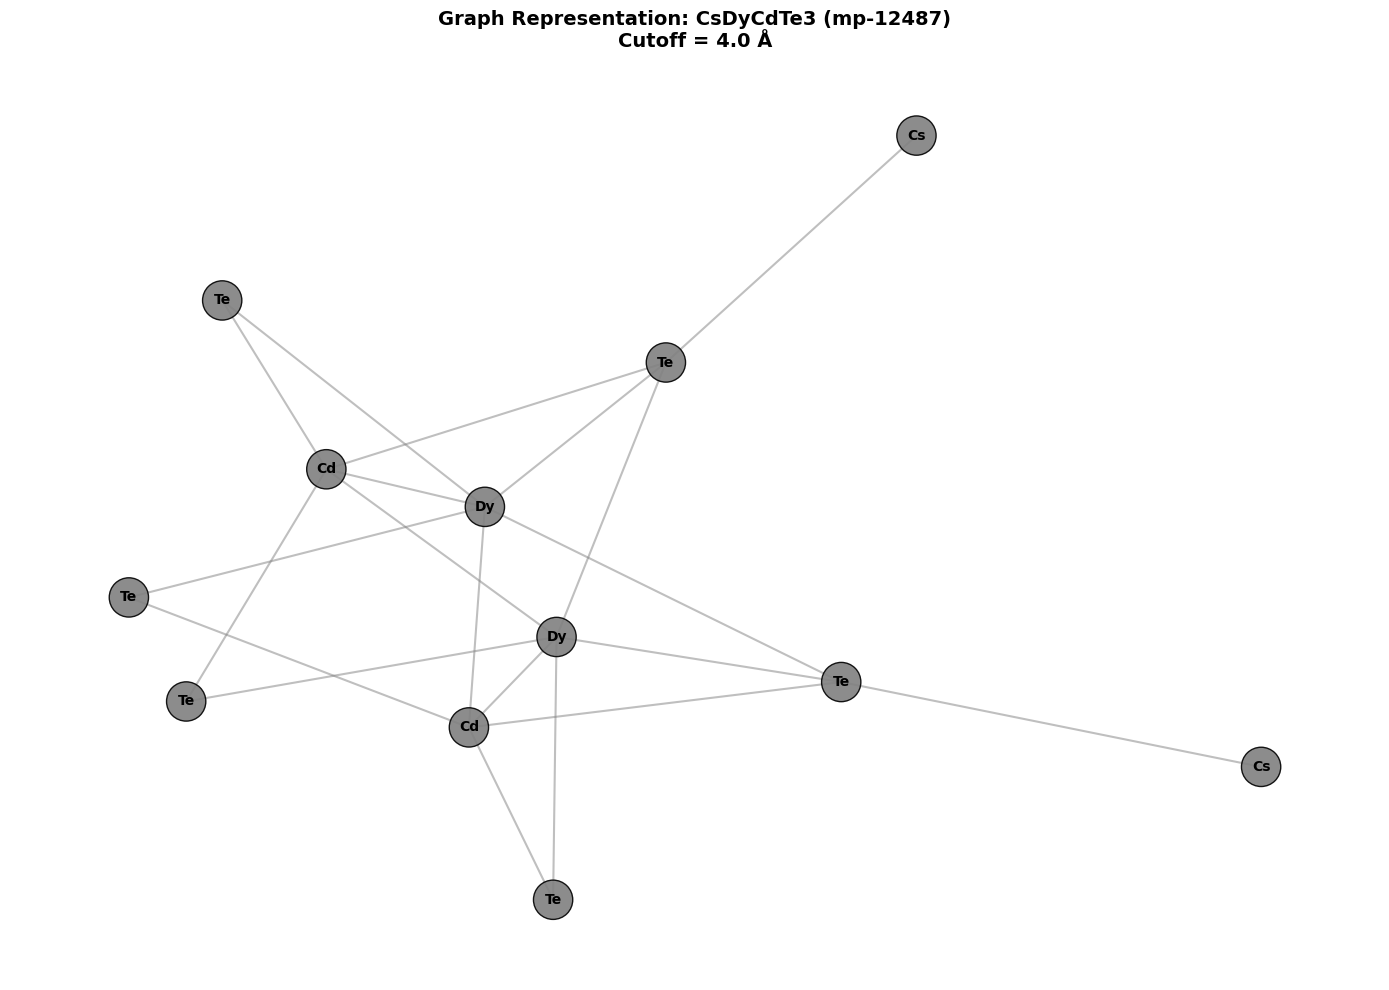

In [14]:
# Compute layout
pos = nx.spring_layout(G, seed=42, k=0.5, iterations=50)

# Create figure
plt.figure(figsize=(14, 10), facecolor="white")

# Draw graph
nx.draw_networkx_nodes(
    G, pos, 
    node_color=colors, 
    edgecolors="black", 
    node_size=800,
    alpha=0.9
)

nx.draw_networkx_edges(
    G, pos, 
    width=1.5, 
    alpha=0.5,
    edge_color="gray"
)

nx.draw_networkx_labels(
    G, pos, 
    labels, 
    font_size=10, 
    font_weight="bold"
)

# Title and formatting
material_id = df_train['material_id'].iloc[idx]
formula = df_train['formula'].iloc[idx]
plt.title(
    f"Graph Representation: {formula} ({material_id})\nCutoff = {cutoff_radius} Å",
    fontsize=14,
    fontweight="bold"
)
plt.axis("off")
plt.tight_layout()
plt.show()

## Part 4: Graph Analysis and Statistics

### Basic Graph Properties

In [15]:
# Basic statistics
print("=== Graph Statistics ===")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
print(f"Graph density: {nx.density(G):.4f}")
print(f"Is connected: {nx.is_connected(G)}")

=== Graph Statistics ===
Number of nodes: 12
Number of edges: 20
Average degree: 3.33
Graph density: 0.3030
Is connected: True


### Degree Distribution

In [16]:
# Degree distribution
degrees = dict(G.degree())
degree_values = list(degrees.values())

print("\n=== Degree Statistics ===")
print(f"Min degree: {min(degree_values)}")
print(f"Max degree: {max(degree_values)}")
print(f"Mean degree: {np.mean(degree_values):.2f}")
print(f"Std degree: {np.std(degree_values):.2f}")


=== Degree Statistics ===
Min degree: 1
Max degree: 6
Mean degree: 3.33
Std degree: 1.80


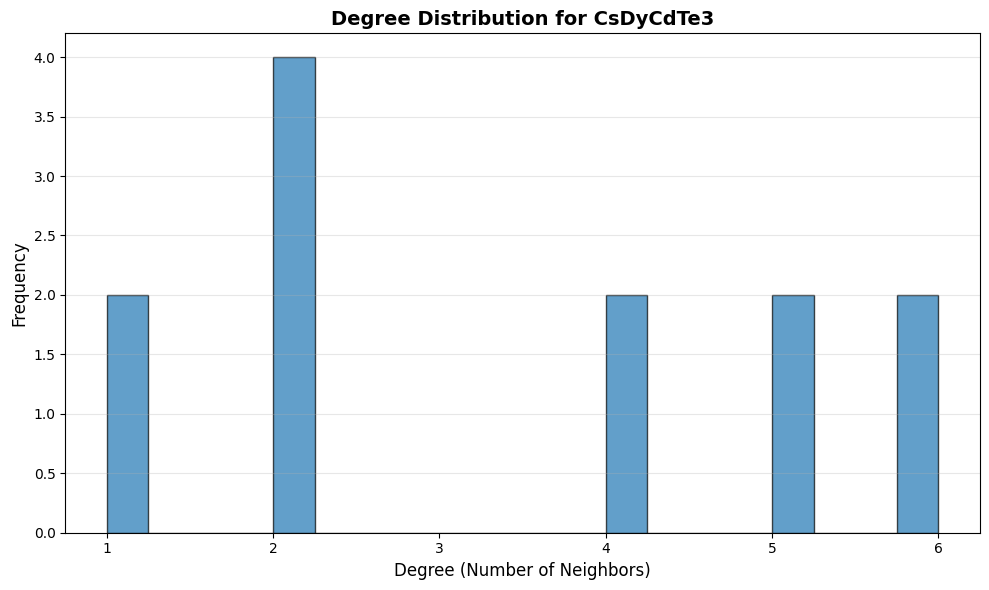

In [17]:
# Plot degree distribution
plt.figure(figsize=(10, 6))
plt.hist(degree_values, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Degree (Number of Neighbors)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Degree Distribution for {formula}', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Node Properties by Element

In [18]:
# Analyze degree by element type
element_degrees = {}
for node in G.nodes():
    element = G.nodes[node]['element']
    degree = G.degree(node)
    if element not in element_degrees:
        element_degrees[element] = []
    element_degrees[element].append(degree)

print("\n=== Average Degree by Element ===")
for element in sorted(element_degrees.keys()):
    avg_deg = np.mean(element_degrees[element])
    count = len(element_degrees[element])
    print(f"{element:>3}: {avg_deg:5.2f} (n={count})")


=== Average Degree by Element ===
 Cd:  5.00 (n=2)
 Cs:  1.00 (n=2)
 Dy:  6.00 (n=2)
 Te:  2.67 (n=6)


### Edge Length Distribution

In [19]:
# Edge length statistics
print("\n=== Edge Length Statistics ===")
print(f"Min length: {np.min(edge_len):.3f} Å")
print(f"Max length: {np.max(edge_len):.3f} Å")
print(f"Mean length: {np.mean(edge_len):.3f} Å")
print(f"Std length: {np.std(edge_len):.3f} Å")


=== Edge Length Statistics ===
Min length: 2.817 Å
Max length: 3.950 Å
Mean length: 3.336 Å
Std length: 0.415 Å


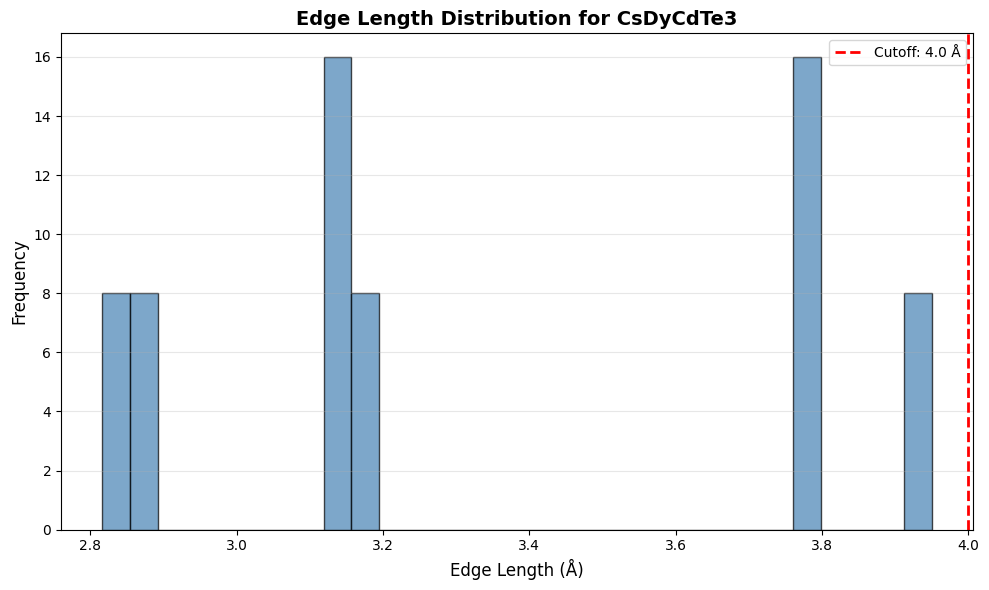

In [20]:
# Plot edge length distribution
plt.figure(figsize=(10, 6))
plt.hist(edge_len, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Edge Length (Å)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Edge Length Distribution for {formula}', fontsize=14, fontweight='bold')
plt.axvline(cutoff_radius, color='red', linestyle='--', linewidth=2, label=f'Cutoff: {cutoff_radius} Å')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Part 5: Compare Multiple Structures

### Analyze Graph Properties Across Dataset

In [21]:
# Analyze properties for multiple structures
def analyze_structure(row_data, cutoff=4.0):
    """Extract graph properties from a structure."""
    s = row_data["structure"]
    pmg = Structure.from_dict(s) if isinstance(s, dict) else s
    atoms = AseAtomsAdaptor.get_atoms(pmg)
    
    i_src, j_dst, d_len = neighbor_list("ijd", atoms, cutoff=cutoff, self_interaction=False)
    
    num_atoms = len(atoms)
    num_edges = len(i_src)
    avg_degree = num_edges / num_atoms if num_atoms > 0 else 0
    
    return {
        'material_id': row_data.get('material_id'),
        'formula': row_data.get('formula'),
        'num_atoms': num_atoms,
        'num_edges': num_edges,
        'avg_degree': avg_degree,
        'min_distance': float(np.min(d_len)) if len(d_len) > 0 else None,
        'max_distance': float(np.max(d_len)) if len(d_len) > 0 else None,
        'mean_distance': float(np.mean(d_len)) if len(d_len) > 0 else None,
    }

In [22]:
# Analyze first 10 structures
print("Analyzing first 10 structures...")
analysis_results = []

for idx in range(min(10, len(df_train))):
    try:
        result = analyze_structure(df_train.iloc[idx], cutoff=cutoff_radius)
        analysis_results.append(result)
    except Exception as e:
        print(f"Error analyzing {df_train.iloc[idx].get('material_id')}: {e}")

df_analysis = pd.DataFrame(analysis_results)
print("\nAnalysis complete!")

Analyzing first 10 structures...

Analysis complete!


In [23]:
# Display analysis results
df_analysis

,material_id,formula,num_atoms,num_edges,avg_degree,min_distance,max_distance,mean_distance
0,mp-12487,CsDyCdTe3,12,64,5.333333,2.816818,3.949649,3.336459
1,mp-3799,GdSF,6,96,16.000000,2.476694,3.992038,3.152794


### Visualize Comparative Statistics

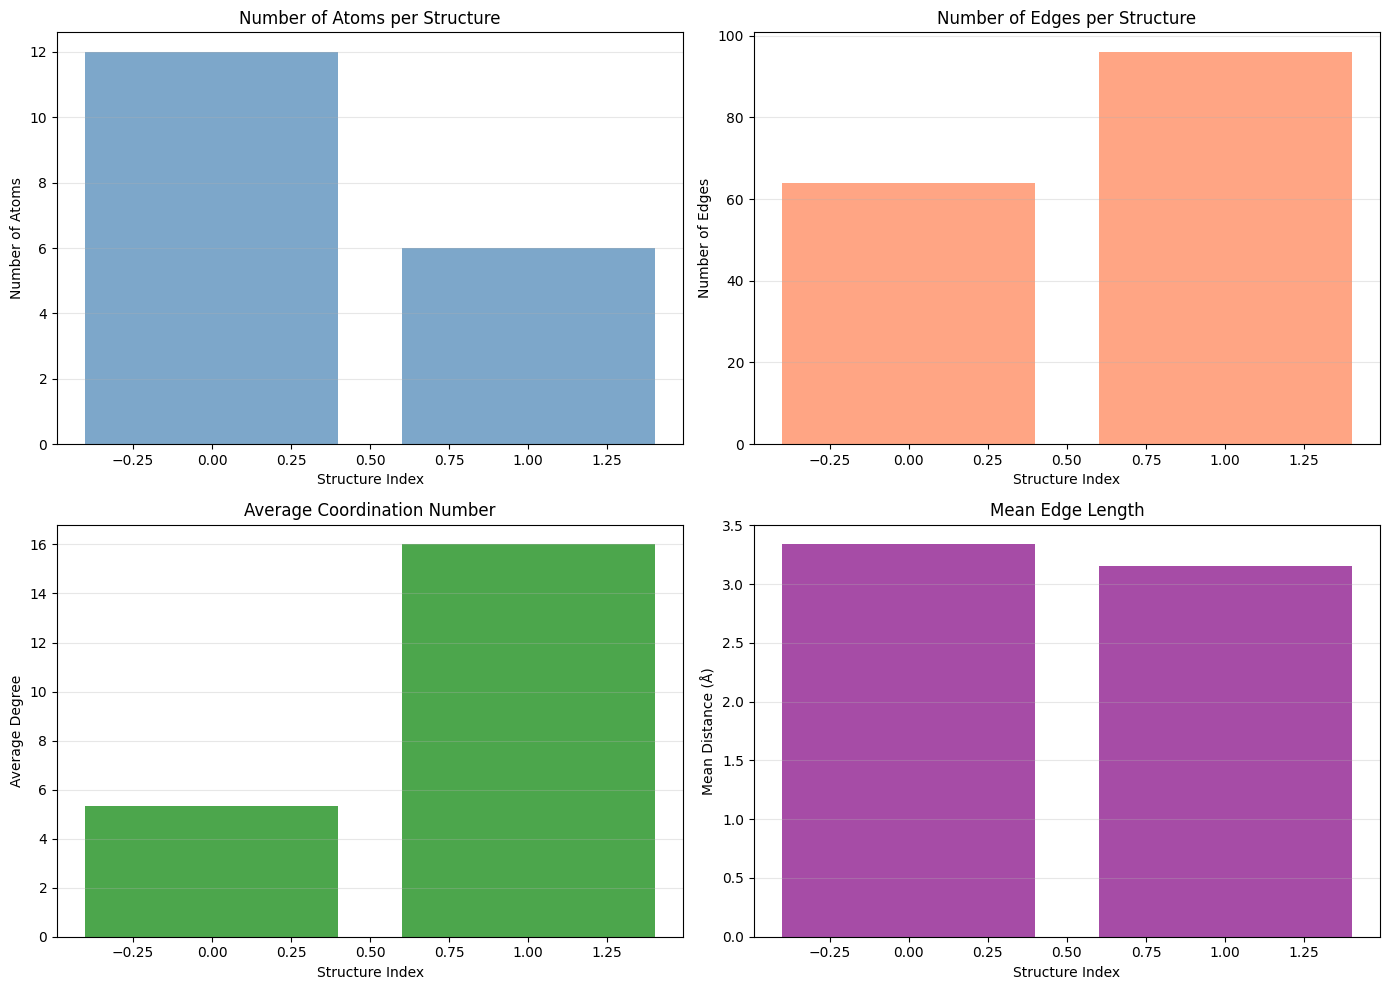

In [24]:
# Create comparative plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Number of atoms
axes[0, 0].bar(range(len(df_analysis)), df_analysis['num_atoms'], color='steelblue', alpha=0.7)
axes[0, 0].set_xlabel('Structure Index')
axes[0, 0].set_ylabel('Number of Atoms')
axes[0, 0].set_title('Number of Atoms per Structure')
axes[0, 0].grid(axis='y', alpha=0.3)

# Number of edges
axes[0, 1].bar(range(len(df_analysis)), df_analysis['num_edges'], color='coral', alpha=0.7)
axes[0, 1].set_xlabel('Structure Index')
axes[0, 1].set_ylabel('Number of Edges')
axes[0, 1].set_title('Number of Edges per Structure')
axes[0, 1].grid(axis='y', alpha=0.3)

# Average degree
axes[1, 0].bar(range(len(df_analysis)), df_analysis['avg_degree'], color='green', alpha=0.7)
axes[1, 0].set_xlabel('Structure Index')
axes[1, 0].set_ylabel('Average Degree')
axes[1, 0].set_title('Average Coordination Number')
axes[1, 0].grid(axis='y', alpha=0.3)

# Mean distance
axes[1, 1].bar(range(len(df_analysis)), df_analysis['mean_distance'], color='purple', alpha=0.7)
axes[1, 1].set_xlabel('Structure Index')
axes[1, 1].set_ylabel('Mean Distance (Å)')
axes[1, 1].set_title('Mean Edge Length')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

We have successfully:
1. ✅ Visualized crystal structures as graphs using NetworkX
2. ✅ Analyzed graph properties (degree distribution, connectivity)
3. ✅ Examined edge length distributions
4. ✅ Compared graph statistics across multiple structures

These visualizations help us understand:
- How crystal structures translate to graph representations
- The local coordination environment of atoms
- The distribution of interatomic distances
- Structural diversity across different materials